In [67]:
import os

input_dir = 'images'
target_dir = 'annotations/trimaps'
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_list = sorted([os.path.join(input_dir, fname) 
                          for fname in os.listdir(input_dir)
                             if fname.endswith('.jpg')])
target_list = sorted([os.path.join(target_dir, fname) 
                          for fname in os.listdir(target_dir)
                             if fname.endswith('.png') and not fname.startswith('.')])

In [68]:
len(input_list), len(target_list)

(7376, 7376)

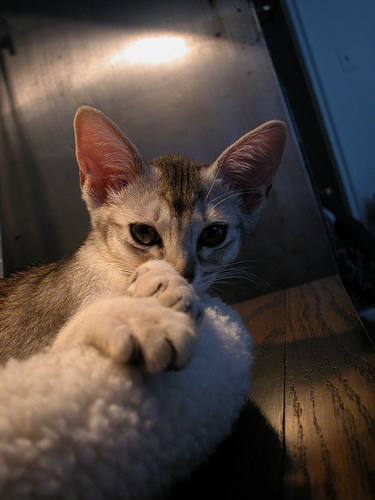

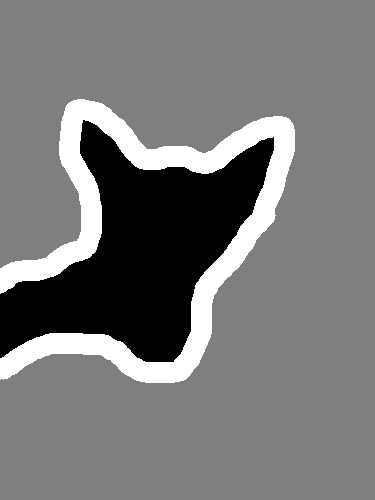

In [69]:
from PIL import ImageOps
from PIL import Image

imgno = 1

img = Image.open(input_list[imgno])
tgt = ImageOps.autocontrast(Image.open(target_list[imgno]))
display(img, tgt)

In [70]:
import cv2
imgno = 20

img = cv2.imread(input_list[1041], cv2.IMREAD_COLOR)
# cv2.imshow('original', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
img.shape, img.transpose((2,0,1)).shape #H W C --> C H W 

((270, 360, 3), (3, 270, 360))

In [71]:
# for removing error file
# for i in range(len(input_list)):
#     ans = cv2.imread(input_list[i], cv2.IMREAD_COLOR) == None
#     if type(ans)==bool:             
#         print(i) 

# kill = [1041, 1048, 1069, 1078, 1094, 3937]
# for i in kill:
#     print(input_list[i])

# Data Preprocessing

In [109]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import io
import os
import numpy as np

In [122]:
class myDataset(Dataset):
    def __init__(self, img_path, target_path, transform=None):
#         self.img_dir = img_dir
#         self.target_dir = target_dir
        self.transform = transform
        
#         self.img_path = sorted([os.path.join(img_dir, fname) 
#                           for fname in os.listdir(img_dir)
#                              if fname.endswith('.jpg')])
#         self.target_path = sorted([os.path.join(target_dir, fname) 
#                           for fname in os.listdir(target_dir)
#                              if fname.endswith('.png') and not fname.startswith('.')])
        self.img_path = img_path
        self.target_path = target_path
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, idx):
        image = io.read_image(self.img_path[idx])
        target = io.read_image(self.target_path[idx])
        
        if self.transform:
            image = np.asarray(transforms.Resize(self.transform)(image))
            target =  np.asarray(transforms.Resize(self.transform)(target))
#             imgae = np.asarray(self.transform(image))
#             target = np.asarray(self.transform(target))
            if image.shape != (3, 200, 200):
                print(idx, image.shape, self.img_path[idx])
        sample = {'image':image, 'target':target}
        
        return sample

In [123]:
from torchvision import transforms
transform = transforms.Compose([transforms.Resize(size=(200,200))])

dataset = myDataset(input_list, target_list, transform=transform)

In [124]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=False)

In [66]:
# # for Removing channel !=3 data
# for i in range(len(input_list)):
#     sh = io.read_image(input_list[i]).shape[0]
#     if sh != 3:
#         print(sh, input_list[i])

4 images/Abyssinian_5.jpg
1 images/Egyptian_Mau_129.jpg
4 images/Egyptian_Mau_14.jpg
4 images/Egyptian_Mau_186.jpg
1 images/staffordshire_bull_terrier_2.jpg
1 images/staffordshire_bull_terrier_22.jpg


Feature batch shape: torch.Size([64, 3, 200, 200])
Labels batch shape: torch.Size([64, 1, 200, 200])


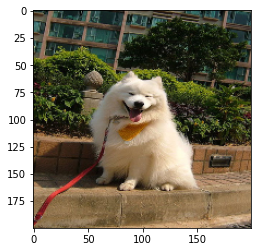

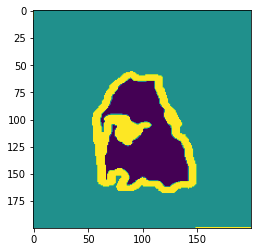

In [125]:
data = next(iter(train_dataloader))

print(f"Feature batch shape: {data['image'].size()}")
print(f"Labels batch shape: {data['target'].size()}")

img = data['image'][2]
label = data['target'][2]

img_t = img.permute(1,2,0)
target_t = label.permute(1,2,0)

plt.imshow(img_t)
plt.show()
plt.imshow(target_t)

In [126]:
import random

val_samples = 1000
random.Random(88).shuffle(input_list)
random.Random(88).shuffle(target_list)

train_input_img_paths = input_list[:-val_samples]
train_target_img_paths = target_list[:-val_samples]
val_input_img_paths = input_list[-val_samples:]
val_target_img_paths = target_list[-val_samples:]

transform = (200,200)
train_gen = myDataset(train_input_img_paths, train_target_img_paths, transform=transform)
val_gen = myDataset(val_input_img_paths, val_target_img_paths, transform=transform)

In [127]:
train_gen[0]

{'image': array([[[ 66,  66,  66, ...,  69,  68,  67],
         [ 65,  65,  65, ...,  68,  70,  70],
         [ 65,  65,  64, ...,  63,  67,  65],
         ...,
         [103, 107, 107, ..., 255, 255, 255],
         [100, 103, 104, ..., 253, 254, 255],
         [ 98, 101, 103, ..., 252, 254, 255]],
 
        [[ 56,  56,  57, ...,  61,  60,  60],
         [ 57,  56,  56, ...,  58,  59,  59],
         [ 56,  56,  55, ...,  59,  60,  58],
         ...,
         [120, 124, 125, ..., 255, 255, 255],
         [117, 120, 121, ..., 253, 254, 255],
         [114, 115, 118, ..., 252, 254, 255]],
 
        [[ 57,  57,  55, ...,  56,  55,  55],
         [ 55,  57,  57, ...,  54,  55,  55],
         [ 57,  57,  58, ...,  54,  56,  55],
         ...,
         [130, 136, 137, ..., 255, 255, 255],
         [125, 130, 130, ..., 253, 254, 255],
         [121, 124, 125, ..., 252, 254, 255]]], dtype=uint8),
 'target': array([[[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..

In [ ]:
# Not work
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, out_channels*depth, kernel_size=kernel_size, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(out_channels*depth, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [136]:
# padding='same' is equal to (kernel_size-1)/2
import torch.nn as nn

class Unet(nn.Module): 
    for batch, data in enumerate(loader_train,1): # 1은 뭐니 > index start point
        # forward
        label = data['target'].to(device)   # 데이터 device로 올리기     
        inputs = data['image'].to(device)

    def __init__(self, num_classes):
        super(Unet, self).__init__()
        
        #inputs =  torch.randn((1, 3,) + img_size) # Batch size, Channel, H, W. # Keras.input = HxWxC
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]
            
            cbr = nn.Sequential(*layers)
            return cbr
            
            
        self.enc0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        def CBR2d_dec(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            layers = []
            layers += [nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                          kernel_size=kernel_size, stride=stride, padding=padding)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]
            
            cbr = nn.Sequential(*layers)
            return cbr
    
        self.enc1_1 = CBR2d(in_channels = 32, out_channels=64)
        self.enc1_2 = CBR2d(in_channels = 64, out_channels=64)
        self.pool1 =  nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.enc1_residual = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=2, padding=0) #Previous acitvation block

        self.enc2_1 = CBR2d(in_channels = 64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels = 128, out_channels=128)
        self.pool2 =  nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.enc2_residual = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=2, padding=0) #Previous acitvation block

        self.enc3_1 = CBR2d(in_channels = 128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels = 256, out_channels=256)
        self.pool3 =  nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.enc3_residual = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=2, padding=0) #Previous acitvation block

        #----------------------------------------------------------------

        self.upsample = nn.Upsample(scale_factor=2)
        
        self.dec1_1 = CBR2d_dec(in_channels = 256, out_channels=256)
        self.dec1_2 = CBR2d_dec(in_channels = 256, out_channels=256)
        self.dec1_residual = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, padding=1)
        
        self.dec2_1 = CBR2d_dec(in_channels = 256, out_channels=128)
        self.dec2_2 = CBR2d_dec(in_channels = 128, out_channels=128)
        self.dec2_residual = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, padding=1)
        
        self.dec3_1 = CBR2d_dec(in_channels = 128, out_channels=64)
        self.dec3_2 = CBR2d_dec(in_channels = 64, out_channels=64)
        self.dec3_residual = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, padding=1)
        
        self.dec4_1 = CBR2d_dec(in_channels =64, out_channels=32)
        self.dec4_2 = CBR2d_dec(in_channels =32, out_channels=32)
        self.dec4_residual = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, padding=1)
        
        self.fc_layer = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=num_classes, kernel_size=3, padding=1),
            nn.Softmax()
        )
        
        
    def forward(self, x):
        x = self.enc0(x)
        previous_block_activation = x # residual
        
        out = self.enc1_1(x)
        out = self.enc1_2(out)
        out = self.pool1(out)
        residual = self.enc1_residual(previous_block_activation)
        out = torch.add(out, residual)
        previous_block_activation = out
        
        out = self.enc2_1(x)
        out = self.enc2_2(out)
        out = self.pool2(out)
        residual = self.enc2_residual(previous_block_activation)
        out = torch.add(out, residual)
        previous_block_activation = out
        
        out = self.enc3_1(x)
        out = self.enc3_2(out)
        out = self.pool3(out)
        residual = self.enc3_residual(previous_block_activation)
        out = torch.add(out, residual)
        previous_block_activation = out
        
        out = self.dec1_1(out)
        out = self.dec1_2(out)
        out = self.upsample(out)
        residual = self.upsample(previous_block_activation)
        residual = self.dec1_residual(residual)
        out = torch.add(out, residual)
        previous_block_activation = out
        
        out = self.dec2_1(out)
        out = self.dec2_2(out)
        out = self.upsample(out)
        residual = self.upsample(previous_block_activation)
        residual = self.dec2_residual(residual)
        out = torch.add(out, residual)
        previous_block_activation = out
        
        out = self.dec3_1(out)
        out = self.dec3_2(out)
        out = self.upsample(out)
        residual = self.upsample(previous_block_activation)
        residual = self.dec3_residual(residual)
        out = torch.add(out, residual)
        previous_block_activation = out
             
        out = self.dec4_1(out)
        out = self.dec4_2(out)
        out = self.upsample(out)
        residual = self.upsample(previous_block_activation)
        residual = self.dec4_residual(residual)
        out = torch.add(out, residual)
        previous_block_activation = out
        
        outputs = self.fc_layer(out)
        return outputs 

NameError: name 'loader_train' is not defined

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(77)
if device == 'cuda':
    torch.cuda.manual_seed_all(77)
print(f"uning: {device}")

 
model = Unet(num_classes).to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

In [ ]:
# 네트워크 저장하기
# train을 마친 네트워크 저장 
# net : 네트워크 파라미터, optim  두개를 dict 형태로 저장
def save(ckpt_dir,net,optim,epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(),'optim':optim.state_dict()},'%s/model_epoch%d.pth'%(ckpt_dir,epoch))

# 네트워크 불러오기
def load(ckpt_dir,net,optim):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net, optim, epoch
    
    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str,isdigit,f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net,optim,epoch

# Training

In [ ]:
loader_train = DataLoader(train_gen, batch_size=batch_size)
loader_val = DataLoader(val_gen, batch_size=batch_size)

train_features, train_labels = next(iter(loader_train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


In [ ]:
from torch.utils.data import DataLoader
loader_train = DataLoader(train_gen, batch_size=batch_size)
loader_val = DataLoader(val_gen, batch_size=batch_size)

batch_size = batch_size
learning_rate = 1e-3
num_epoch = 20

optim = torch.optim.Adam(net.parameters(), lr = lr ) 


for epoch in range(start_epoch+1,num_epoch +1):
    loss_arr = []

    for batch, data in enumerate(loader_train,1): # 1은 뭐니 > index start point
        # forward
        
        label = data['label'].to(device)   # 데이터 device로 올리기     
        inputs = data['input'].to(device)
        output = model(inputs) 

        # backward
        optim.zero_grad()  # gradient 초기화
        loss = fn_loss(output, label)  # output과 label 사이의 loss 계산
        loss.backward() # gradient backpropagation
        optim.step() # backpropa 된 gradient를 이용해서 각 layer의 parameters update

        # save loss
        loss_arr += [loss.item()]

        # tensorbord에 결과값들 저정하기
        label = fn_tonumpy(label)
        inputs = fn_tonumpy(fn_denorm(inputs,0.5,0.5))
        output = fn_tonumpy(fn_classifier(output))

        writer_train.add_image('label', label, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('input', inputs, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('output', output, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')

    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)
    
    # validation
    with torch.no_grad(): # validation 이기 때문에 backpropa 진행 x, 학습된 네트워크가 정답과 얼마나 가까운지 loss만 계산
        net.eval() # 네트워크를 evaluation 용으로 선언
        loss_arr = []

        for batch, data in enumerate(loader_val,1):
            # forward
            label = data['label'].to(device)
            inputs = data['input'].to(device)
            output = net(inputs)

            # loss 
            loss = fn_loss(output,label)
            loss_arr += [loss.item()]
            print('valid : epoch %04d / %04d | Batch %04d \ %04d | Loss %04d'%(epoch,num_epoch,batch,num_val_for_epoch,np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            inputs = fn_tonumpy(fn_denorm(inputs, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_classifier(output))

            writer_val.add_image('label', label, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('input', inputs, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('output', output, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        # epoch이 끝날때 마다 네트워크 저장
        save(ckpt_dir=ckpt_dir, net = net, optim = optim, epoch = epoch)

writer_train.close()
writer_val.close()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=img_size + (3,))
inputs

In [ ]:
inputs =  torch.randn((1, 3,) + img_size) # Batch size, Channel, H, W. # Keras.input = HxWxC

x = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)(inputs)
x = nn.BatchNorm2d(32)(x)

In [ ]:
x.shape

In [ ]:
inputs = keras.Input(shape=img_size + (3,))
    
x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)


In [ ]:
count = 0

for filters in [64, 128, 256]:
    print(filters)

In [ ]:
count

In [ ]:
input1 = layers.Input(shape=(16,))
x1 = layers.Dense(8, activation='relu')(input1)
input2 = layers.Input(shape=(32,))
x2 = layers.Dense(8, activation='relu')(input2)

# equivalent to `added = tf.keras.layers.add([x1, x2])`

added = layers.add([x1, x2])

In [ ]:
added

In [ ]:
input = torch.arange(1, 5, dtype=torch.float32).view(1, 1, 2, 2)
input.shape, input

In [ ]:
m = torch.cat(input, input, dim=1)

In [ ]:
m.shape, m

In [ ]:
 input_shape = (2, 1, 3, 2)
x = np.arange(np.prod((input_shape))).reshape(input_shape)
x.shape

In [ ]:
y = layers.UpSampling2D(size=2)(x)
y

In [ ]:
for filters, i in enumerate([256, 128, 64, 32]):
    print(filters, i)

In [ ]:
def compressWord(word, k):
    dic = {}
    before = str("0"+word)
    result = ""
    
    for i, w in enumerate(word):
        if not w in dic:
            dic[w]=1
        else:
            if before[i] == w:
                dic[w] +=1
            
    for w in word:
        if dic[w] != k:
            result = result+w

    if result == word:
        return [result]
    else:
        return compressWord(result, k)



In [ ]:
re = compressWord("acdddcca", 3)
re